In [ ]:
# default_exp 
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
from FRED.embed import *
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device mps


# 03e Flow Prediction Network

In [ ]:
# export
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from FRED.data_processing import flashlight_affinity_matrix, diffusion_map_from_affinities, flow_neighbors
class FlowPredictionDataset(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, 
                X, 
                velocities, 
                labels, 
                sigma="automatic", 
                ts = (1,2,4,8),
                prior_embedding = "diffusion map", 
                t_dmap = 1, 
                dmap_coords_to_use = 2,):
        # Step 0: Convert data into tensors
        self.X = torch.tensor(X).float()
        self.velocities = torch.tensor(velocities).float()
        self.labels = labels
        self.n_nodes = self.X.shape[0]
        self.eps = 1e-3
        # Step 1. Build graph on input data, using flashlight kernel
        print("finding diffusion operator")
        self.A = flashlight_affinity_matrix(self.X, self.velocities, sigma = sigma)
        self.A[self.A < self.eps] = 0
        # visualize affinity matrix
        plt.imshow(self.A.numpy())
        # Construct diffusion matrix as row normalized adjacency matrix
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        # threshold values less than epsilon to zero
        # We convert P_graph into sparse format to efficiently power
        self.P_graph = self.P_graph.to_sparse().coalesce()
        # Compute powers of P (really fast, because it's sparse : ) 
        self.P_graph_ts = [self.P_graph]
        print("Powering diffusion operator")
        for t in tqdm(ts[1:]):
            # TODO Can make more efficient by using prior powers
            powered_matrix = torch.linalg.matrix_power(self.P_graph_ts[0], t).coalesce()
            dense_powered = powered_matrix.to_dense()
            dense_powered[dense_powered < self.eps] = 0
            sparse_powered = dense_powered.to_sparse()
            self.P_graph_ts.append(sparse_powered)
            # TODO: Could proactively prune probs below eps threshold here.


        # Step 2. Take a diffusion map of the data
        # These will become our 'precomputed distances' which we use to regularize the embedding
        if prior_embedding == "diffusion map":
            print("computing diffusion distances")
            P_dense = self.P_graph.clone().to_dense()
            P_graph_symmetrized = P_dense + P_dense.T
            diff_map = diffusion_map_from_affinities(
                # TODO: May need to convert back to dense form.
                P_graph_symmetrized, t=t_dmap, plot_evals=False 
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            self.diff_coords = torch.tensor(self.diff_coords.copy()).float()
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation
        
        # Step 3. Decompose the affinity matrix into a list of indices [i,j], which we use to form batches
        # To prevent this from making the batch have size n x n, we use the *nonzero* indices of the 
        # sparse powered diffusion matrices.
        # But each powered diffusion matrix will have different nonzero values. Hence, we want the union of all relationships which
        # at some level of diffusion, are nonzero
        # print("sparse Pts are",self.P_graph_ts)
        all_P_values = self.P_graph_ts[0]
        for i in range(1,len(ts)):
            # print(i)
            all_P_values += all_P_values + self.P_graph_ts[i]
            all_P_values = all_P_values.coalesce()
        self.diffusion_indices = all_P_values.indices() 
        # returns matrix whose columns are indices
        # tensor([[0, 1, 1],
        #         [2, 0, 2]])
        # convert to matrix whose rows are indices
        self.diffusion_indices = self.diffusion_indices.transpose(0,1)
    def __len__(self):
        return len(self.diffusion_indices)
    def __getitem__(self, idx):
        # idx specifies the ith tuple of points in the diffusion indices.
        happy_couple = self.diffusion_indices[idx]
        # print("hc is",happy_couple)
        # Construct diffusion probabilities into a list of tensors
        probs = torch.zeros(len(self.P_graph_ts))
        for i, Pt in enumerate(self.P_graph_ts):
            probs[i] = Pt[happy_couple[0]][happy_couple[1]]
        # print("got Pt probs just fine")
        # print("first sum worked")
        # Fetch points from X
        points = self.X[happy_couple]
        # print("got points just fine")
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "probs":probs,
            "distance":self.precomputed_distances[happy_couple[0]][happy_couple[1]],
            "points":points,
        }
        return return_dict

## Testing the new dataset class

In [ ]:
from FRED.datasets import directed_spiral
X, flows, labels = directed_spiral(num_nodes=1000)

finding diffusion operator
Set sigma =  0.20019817
Powering diffusion operator


  0%|          | 0/3 [00:00<?, ?it/s]

computing diffusion distances


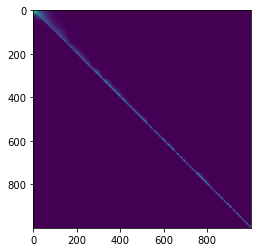

In [ ]:
ds = FlowPredictionDataset(X, flows, labels)

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(ds, batch_size=512, num_workers=0)

In [ ]:
for d in tqdm(dataloader):
    # print(d)
    pass

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
len(ds)

132491

# The Network

In [ ]:
# export
import torch
import torch.nn as nn

class ManifoldFlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        embedding_dimension=2,
        ts = [1,2,4,8],
        embedder_shape=[3, 4, 8, 4, 2],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        sigma=0.5,
        flow_strength=0.5,
        smoothness_grid=True,
    ):
        super().__init__()
        self.device = device
        self.embedding_dimension = embedding_dimension
        # embedding parameters
        self.sigma = sigma
        self.flow_strength = flow_strength
        self.smoothness_grid = smoothness_grid
        self.ts = ts
        # Initialize autoencoder and flow artist

        self.embedder, self.decoder = auto_encoder(embedder_shape, device=self.device)
        self.flowArtist = flow_artist(dim=self.embedding_dimension, device=self.device)
        # # training ops
        # self.KLD = nn.KLDivLoss(reduction="batchmean", log_target=False)
        self.MSE = nn.MSELoss()
        # self.KLD = homemade_KLD # when running on mac
        self.epsilon = 1e-6  # set zeros to eps

    def diffusion_flow_loss(self):
        # Predict flow probabilities to points based on a local diffusion matrix, constructed out of the batch
        # We use the embedded points and our FlowArtist to predict diffusion probabilities
        # Steps:
        # 1. Build diffusion matrix (using automatic kernel selection with flashlight kernel)
        A = flashlight_affinity_matrix(self.embedded_points, self.embedded_flows, sigma="automatic", k = 10)
        P = F.normalize(A, p=1, dim=1)
        # 2. Power diffusion matrix
        self.Pts = [torch.linalg.matrix_power(P,t) for t in self.ts]
        # 3. Take 

        return loss

    def forward(self, data, loss_weights):
        # Extract data from batch
        # By default, point positions are batched two at a time. 
        # We need to flatten along the second dimension
        X = data["points"].flatten(start_dim=1, end_dim=1)
        self.embedded_points = self.embedder(X)
        self.embedded_flows = self.flowArtist(self.embedded_points)
        
        self.embedded_flows = self.flowArtist(self.embedded_points)
        losses = self.loss(data, loss_weights)
        return losses

In [ ]:
dps = d["points"]
dps

tensor([[[-8.7701,  2.5721,  0.0000],
         [-9.1631,  1.4145,  0.0000]],

        [[-8.7701,  2.5721,  0.0000],
         [-9.2229,  1.1776,  0.0000]],

        [[-8.7701,  2.5721,  0.0000],
         [-9.2772,  0.9355,  0.0000]],

        ...,

        [[-9.3938,  0.2575,  0.0000],
         [-9.3979,  0.2269,  0.0000]],

        [[-9.3938,  0.2575,  0.0000],
         [-9.4027,  0.1899,  0.0000]],

        [[-9.3979,  0.2269,  0.0000],
         [-9.4027,  0.1899,  0.0000]]])

In [ ]:
dps.flatten(start_dim=0,end_dim=1)

tensor([[-8.7701,  2.5721,  0.0000],
        [-9.1631,  1.4145,  0.0000],
        [-8.7701,  2.5721,  0.0000],
        ...,
        [-9.4027,  0.1899,  0.0000],
        [-9.3979,  0.2269,  0.0000],
        [-9.4027,  0.1899,  0.0000]])